In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
import numpy as np
from sklearn import preprocessing
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

#### Load and prepare data

In [2]:
ouput_path = 'data/'

def load_data(path_file, data_file, remove_no_path=False):
    frame = pd.read_csv(path_file)
    if remove_no_path:
        frame = frame[(frame.path != 'NO_PATH_A') & (frame.path != 'NO_PATH_B')]
    #frame = frame[frame.most_frequent_percentage >= 0.6]
    data_frame = pd.read_csv('data.csv')
    data_frame = data_frame[data_frame.sentence.isin(frame.sentence.values.tolist())]
    output_name = 'paths-from-input-{}-empty-paths-{}.csv'.format(path_file.replace('.csv',''),(not remove_no_path))
    return frame, data_frame, output_name

paths, data, output_name = load_data('paths.csv', 'data.csv', remove_no_path=True)
#paths, data = load_data('paths.csv', 'data.csv', remove_no_path=False)

In [3]:
vocab_size=5000
maxlen = 20

# transform labels into 3d tensors for lstm
paths_list = paths['path'].values.tolist()
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(paths_list)
input_train = tokenizer.texts_to_sequences(paths_list)
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_train = input_train.reshape((len(paths_list),maxlen,1))

# create target labels, one for each path
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(paths_list)
y_train =  to_categorical(label_encoder.transform(paths_list))

print('{} paths total'.format(len(paths)))
print('{} different (target) paths'.format(y_train[0].shape[0]))

3638 paths total
2902 different (target) paths


#### Train the network

In [4]:
def plot_lines(first,second):
    %matplotlib inline
    plt.plot(history.history[first[0]],color=first[1])
    plt.plot(history.history[second[0]],linestyle='--',color=second[1])
    #plt.plot(history.history['loss'],color='red')
    #plt.plot(history.history['val_loss'],color='orangered',linestyle='--')
    plt.title('{} vs {}'.format(first[0],second[0]))
    plt.xlabel('epoch')
    plt.legend([first[0],second[0]])
    plt.figure(figsize=(5,5))
    plt.show()
    

In [5]:
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, MaxPooling1D, AveragePooling1D
from keras.models import Sequential
from keras import regularizers
neurons = 4
dropout = 0.0
rnn_dropout = 0.0
model = Sequential()

model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=True, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))
model.add(LSTM(neurons,return_sequences=False, input_shape=(maxlen,1),dropout=dropout,recurrent_dropout=rnn_dropout))


model.add(Dense(y_train[0].shape[0],activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(input_train, y_train,
epochs=100, batch_size=64,shuffle=True, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 4)             96        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 4)                 144       
__________

2910/2910 [==============================] - 4s 1ms/step - loss: 7.4125 - acc: 0.0430 - val_loss: 13.3069 - val_acc: 0.0412
Epoch 51/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4128 - acc: 0.0430 - val_loss: 13.3785 - val_acc: 0.0412
Epoch 52/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4126 - acc: 0.0430 - val_loss: 13.4464 - val_acc: 0.0412
Epoch 53/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4126 - acc: 0.0430 - val_loss: 13.5109 - val_acc: 0.0412
Epoch 54/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4127 - acc: 0.0430 - val_loss: 13.5725 - val_acc: 0.0412
Epoch 55/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4131 - acc: 0.0430 - val_loss: 13.6307 - val_acc: 0.0412
Epoch 56/100
2910/2910 [==============================] - 4s 1ms/step - loss: 7.4131 - acc: 0.0430 - val_loss: 13.6851 - val_acc: 0.0412
Epoch 57/100
2910/2910 [==============================

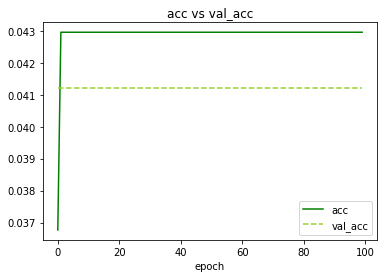

<Figure size 360x360 with 0 Axes>

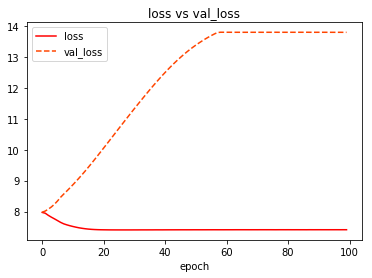

<Figure size 360x360 with 0 Axes>

In [6]:
plot_lines(('acc','green'),('val_acc', 'yellowgreen'))
plot_lines(('loss', 'red'), ('val_loss', 'orangered'))

#### Prepare the embeddings

In [7]:
layer = model.layers[-2]
assert type(layer) == LSTM
assert type(model.layers[-1]) == Dense
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=layer.output)
intermediate_output = intermediate_layer_model.predict(input_train)
layer

### Average Embedding

In [8]:
from collections import defaultdict
assert len(paths) == len(intermediate_output)

embedding_dict = defaultdict(list)
mean_embedding_dict = {}
idx = 0
for i, row in paths.iterrows():
    embedding_dict[row['sentence']].append(intermediate_output[idx])
    idx += 1

assert len(embedding_dict)== len(data)

for k,v in embedding_dict.items():
    adder = np.zeros(v[0].shape)
    for val in v:
        adder += val
    adder /= len(v)
    mean_embedding_dict[k] = adder
    
assert len(mean_embedding_dict)== len(data)

In [9]:
X = []
y = []
plot_data = []
plot_x = []
idx = 0
embedding_df = pd.DataFrame(columns=['id', 'sentence', 'label', 'embedding', 'paths'])
for k,v in mean_embedding_dict.items():
    f_slice = paths[paths.sentence == k]
    label = f_slice.most_frequent_label.values.tolist()[0]
    f_paths = f_slice.path.values.tolist()
    embedding_df.loc[idx] = [f_slice.id.values.tolist()[0], f_slice.sentence.values.tolist()[0],label,
                             v.reshape(-1,1).squeeze().tolist(), f_paths]
    idx+=1
    # prepare results for classification
    X.append(v.reshape(-1,1).squeeze().tolist())
    y.append(label)
    
    # prepare results for t-sne plot
    plot_x.append(v)
    plot_data.append( (label,k,'\n'.join(paths)) )

In [10]:
assert len(embedding_df) == len(data)
embedding_df.to_csv(output_name)

### Plot

In [11]:
X_embedded = TSNE(n_components=2,verbose=1).fit_transform(plot_x)
plot_frame = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
for i,x in enumerate(X_embedded):
    plot_frame.loc[i] = [x[0],x[1],plot_data[i][0],plot_data[i][1],plot_data[i][2]]
    
def build_source(label, df):
    df = df[df['class'] == label]
    return ColumnDataSource(data=dict(
    x=df.x.values.tolist(),
    y=df.y.values.tolist(),
    sentence=df.sentence.tolist(),
    path=df.path.tolist(),
    label=df['class'].tolist()))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1809 samples in 0.004s...
[t-SNE] Computed neighbors for 1809 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1809
[t-SNE] Computed conditional probabilities for sample 1809 / 1809
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.527824
[t-SNE] Error after 1000 iterations: 2.144927


In [12]:
colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
colors = [colormap[x] for x in plot_frame['class']]

# GROUP tooltips
hover = HoverTool(tooltips=[
    ("Sentence", "@sentence"),
    ("Path", "@path"),
    ("label", "@label"),
])

p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
p.add_tools(hover)

p.cross(x='x', y='y', source=build_source('NONE', plot_frame),size=5,color='gray')
p.circle(x='x', y='y', source=build_source('WORSE', plot_frame) ,size=5,color='red')
p.circle(x='x', y='y', source=build_source('BETTER', plot_frame),size=5,color='green')


show(p)

### Classification Test

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
kf = StratifiedKFold(n_splits=2, random_state=1337)
for train_index, test_index in kf.split(X,y):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    log = LogisticRegression()
    log.fit(X_train, y_train)
    pred = log.predict(X_test)
    print(classification_report(pred,y_test,labels=['BETTER', 'WORSE', 'NONE']))

             precision    recall  f1-score   support

     BETTER       0.00      0.00      0.00         0
      WORSE       0.00      0.00      0.00         0
       NONE       1.00      0.70      0.83       905

avg / total       1.00      0.70      0.83       905

             precision    recall  f1-score   support

     BETTER       0.00      0.00      0.00         0
      WORSE       0.00      0.00      0.00         0
       NONE       1.00      0.70      0.83       904

avg / total       1.00      0.70      0.83       904



/home/5franzek/import/ve/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
